# Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf
from tensorflow import keras
import os
import time
import random
import glob # Khoa's stuff
from IPython import display
from tqdm import tqdm # for training progress
import wave

# Utilities
import scipy.io.wavfile as wav
from utils.audio_spectrogram import stft_np as stft
from utils.img_processing import mask_image
from PIL import Image

# Models
from models.deepfake_generator import combined_generator, generator # Generator is only for plotting
from models.visual_quality_discriminator import quality_discriminator

2023-02-11 18:52:00.732581: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-11 18:52:01.314891: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/khoa/.local/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-11/lib64:
2023-02-11 18:52:01.314953: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/khoa/.local/lib/python3.10/site-pac

# Constants

In [18]:
EPOCHS = 1000
BATCH_SIZE = 100

# Get randomized dataset batch
We can't possibly hold everything at once

In [3]:
def khoas_get_batch(batch_size, seed=0):
    """
    Khoa's custom function
    The real stuff needs the real function
    """
    random.seed(seed)

    data_path = './dataset/train/real/'

    # Go through datapath, append every png file to the png list.
    png_list = []
    for file in os.listdir(data_path):
        if file.endswith('png'):
            png_list.append(file)

    image_samples = []
    gen_input_samples = [] # Specifically to work with Huy's data, should change
    audio_samples = []
    print("Choosing random data batch")
    batch = random.sample(png_list, batch_size)
    print("Batch chosen, processing")
    # Go through a list of batch-size elements chosen randomly from png_list
    task = tqdm(total=len(batch*5), position=0)
    for img_name in batch:
        img_name = data_path + img_name
        name = img_name[:-4] # name of file without extension
        audio_name = name + '.wav'# name of audio file
        # TODO duct-tape solution, figure out how to remove it from dataset
        samplerate, samples = wav.read(audio_name)
        if len(samples) < 1450:
            continue

        img = Image.open(img_name)
        # Convert image to numpy array of 3 dimensions
        img_arr = np.asarray(img)
    
        name_no_digit = ''.join([i for i in name if not i.isdigit()])  # PNG name is sth like REAL_aerzetktyh_0. name_no_digit will be sth like REAL_aerzetktyh
        pose_prior_name = img_name


        count = 0
        # randomly choose a pose prior of the same person
        while pose_prior_name == img_name and count < 100:
            count+=1
            pose_prior_name = random.choice(glob.glob(name_no_digit+'*.png')) # So if we choose sth like REAL_aerzetkyh_0.png as input to feed in, the reference image
                                                                           # would be sth like REAL_aerzetkyh_67.png

        if count == 100: # No possible pose-prior found
            continue
        
        # Only append the image if a pose-prior can be found
        image_samples.append(img_arr / 255)  #  Normalization of image
        task.update()

        pose_prior = Image.open(pose_prior_name)  # Post_prior is just the reference image in the same video as the one we're going to feed to the generator
        pose_prior = np.asarray(pose_prior)
        pose_prior = pose_prior / 255
        task.update()

        # img_masked = img_arr.copy()
        # create a mask  Crop out the lower part of the image.
        # img_masked[256//2:,...] = 0  
        img_masked = mask_image(img_name)
        img_masked = img_masked / 255
        task.update()

        # concatenate masked ground truth to pose prior
        img_concat = np.concatenate([pose_prior, img_masked], axis=2)
        # expected shape (256, 256, 6)
        gen_input_samples.append(img_concat)
        task.update()
        
        audio_arr = stft(audio_name, 2 ** 10) # Generate the spectrogram out of audio segment.
        
        audio_samples.append(audio_arr)
        task.update()
    print("Batch processed")
    image_samples = np.asarray(image_samples).astype('float32')
    gen_input_samples = np.asarray(gen_input_samples).astype('float32')
    audio_samples = np.asarray(audio_samples)
    print("Batch converted to numpy arrays. Returning")
        
    # It should go without saying that the order needs to match
    return image_samples, gen_input_samples, audio_samples

In [4]:
def generate_and_save_images(model, epoch, original_images, gen_imgs, audio_samples, save=True):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions, _ = model([gen_imgs, audio_samples])

  print("Mean Absolute Difference {}".format(np.mean(np.absolute(predictions[1]-predictions[0]))))

  fig = plt.figure(figsize=(2, 2))

  for i in range(predictions.shape[0]):
      plt.subplot(2, 2, i+1)
      plt.imshow(predictions[i])
      plt.axis('off')

      plt.subplot(2, 2, i+3)
      plt.imshow(original_images[i])
      plt.axis('off')
  
  if save:
    plt.savefig("./generated_images/image_at_epoch_{:04d}.png".format(epoch))
  plt.show()

# Test models

Choosing random data batch
Batch chosen, processing


100%|██████████| 10/10 [00:00<00:00, 17.85it/s]
2023-02-11 18:52:02.857385: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-11 18:52:02.889979: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-11 18:52:02.890154: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-11 18:52:02.890686: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To 

Batch processed
Batch converted to numpy arrays. Returning
(2, 256, 256, 6)


e NUMA node, so returning NUMA node zero
2023-02-11 18:52:02.891437: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-11 18:52:02.891555: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-11 18:52:03.270358: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-11 18:52:03.270538: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-11 18:52:03.270665:

Mean Absolute Difference 5.578392665483989e-05


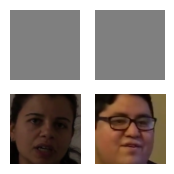

In [5]:
test_img_arrs, test_img_concats, test_audio_arrs = khoas_get_batch(2, 0)
print(test_img_concats.shape)
# Define models
qual_disc = quality_discriminator()
gen = combined_generator(qual_disc)


generated_img, con_loss = gen([test_img_concats, test_audio_arrs])

generate_and_save_images(gen, 0, test_img_arrs, test_img_concats, test_audio_arrs)


# Plot Models

In [6]:
# gen_plot = generator()
# keras.utils.plot_model(gen_plot, "generator_plot.png", show_shapes=True)

# Define Loss Functions and Optimizers

In [7]:
# quality_discriminator_loss = keras.losses.BinaryCrossentropy(from_logits=True)
# generator_loss = keras.losses.MeanAbsoluteError() # Also known as L1 reconstruction loss

# generator_optimizer = tf.keras.optimizers.Adam(1e-3)
# quality_discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

# Misc

# Process generator input data
Essentially a reference face (pose prior) concatenated channel-wise with the masked original face

In [9]:
# gen_loss_prog = keras.utils.Progbar(None, unit_name='generator_loss')
# disc_loss_prog = keras.utils.Progbar(None, unit_name='quality_discriminator_loss')
# disc_real_loss_prog = keras.utils.Progbar(None, unit_name='quality_discriminator_real_loss')
# @tf.function()
def train_step(images, gen_imgs, audio_samples):
    disc_loss, real_loss, gen_loss = 0., 0., 0.
    #with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    real = np.zeros((len(images), 1))
    fake = np.ones((len(images), 1))

    generated_images, gd_loss = gen([gen_imgs, audio_samples])
    
    # train discriminator
    disc_loss = qual_disc.train_on_batch(generated_images, fake)
    real_loss = qual_disc.train_on_batch(images, real)

    # gen_loss = generator_loss(images, generated_images)
    # disc_loss = quality_discriminator_loss(real_output, fake_output)

    # gradients_of_generator =  gen_tape.gradient(gen_loss, gen.trainable_variables)
    # gradients_of_quality_discriminator = disc_tape.gradient(disc_loss, qual_disc.trainable_variables)

    # generator_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))
    # quality_discriminator_optimizer.apply_gradients(zip(gradients_of_quality_discriminator, qual_disc.trainable_variables))

    # train generator
    total, mae, adv= gen.train_on_batch([gen_imgs, audio_samples], [images, real]) 
    print("Disc Loss: {} Real Loss: {} Total Gen Loss: {} MAE: {} Adv Loss: {}".format(disc_loss, real_loss, total, mae, adv))

    # gen_loss_prog.update(gen_loss)
    # disc_loss_prog.update(disc_loss)
    # disc_real_loss_prog.update(real_loss)

# Train

In [10]:
def train_in_batch(batch, epoch):
    start = time.time()
    train_step(batch[0], batch[1], batch[2])

    # Produces images for the GIF
    generate_and_save_images(gen, epoch + 1, test_img_arrs, test_img_concats, test_audio_arrs) # Maybe my face?
    # if (epoch+1) % 15 == 0:
    #     checkpoint.save(file_prefix = checkpoint_prefix)
    print('Time for epoch {} is {} sec. Image Saved'.format(epoch+1, time.time()-start))
    

Mean Absolute Difference 0.10003050416707993


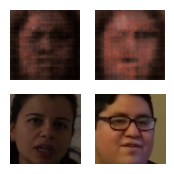

In [11]:
for epoch in range(700, EPOCHS):
    print("Epoch {} starting".format(epoch+1))
    start = time.time()
    batch = khoas_get_batch(BATCH_SIZE, epoch+1)
    display.clear_output(wait=True)
    print(f"Batch Acquisition time {time.time() - start} for epoch {epoch + 1}. Training...")
    train_in_batch(batch, epoch)

display.clear_output(wait=True)
generate_and_save_images(gen, epoch + 1, test_img_arrs, test_img_concats, test_audio_arrs) # Maybe my face?

In [13]:
# gen.save('./saved_models/generator/khoa')

INFO:tensorflow:Assets written to: ./saved_models/generator/khoa/assets


INFO:tensorflow:Assets written to: ./saved_models/generator/khoa/assets


# Demo

Choosing random data batch
Batch chosen, processing


100%|██████████| 10/10 [00:00<00:00, 17.78it/s]

Batch processed
Batch converted to numpy arrays. Returning
1/1 [==============================] - 0s 17ms/step
Mean Absolute Difference 0.07899759709835052


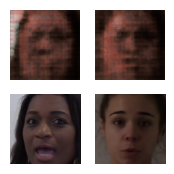

In [16]:
images, img_concats, audio_samples = khoas_get_batch(2, 40000)
predictions = gen.predict([img_concats, audio_samples])

generate_and_save_images(gen, 1000, images, img_concats, audio_samples, False)

In [12]:
import imageio

anim_file = 'deepfake.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('generated_images/image_at_epoch*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

    

# Test